# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch import nn
from torch import optim

import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                              train=True,
                                              transform=transforms.ToTensor(), 
                                              download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            download=True,
                                            transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=50,
                                          shuffle=False)


image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [3]:
classes = train_dataset.classes

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 8 * hidden_dim) ##
        self.fc2 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.fc3 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim) 
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x) ##
        x = F.relu(x) ##
        x = self.fc5(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.relu(x) ##
        x = self.fc5(x) ##
        x = F.softmax(x)
        return x


net = Net(3072, 100, 10)
net.train()

Net(
  (fc1): Linear(in_features=3072, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.001)

In [6]:
num_epochs = 3  ##
with torch.cuda.device("cuda:0"): ##
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_items = 0.0


        for i, data in enumerate(train_loader):
            inputs, labels = data[0], data[1]

             # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = net(inputs)
            # Рассчитываем лосс-функцию
            loss = criterion(outputs, labels)
            # Делаем шаг назад по лоссу
            loss.backward()
            # Делаем шаг нашего оптимайзера
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            if i % 500 == 0:    # печатаем каждые 500 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}')
                running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/3]. Step [1/782]. Loss: 0.036
Epoch [1/3]. Step [501/782]. Loss: 0.032
Epoch [2/3]. Step [1/782]. Loss: 0.033
Epoch [2/3]. Step [501/782]. Loss: 0.029
Epoch [3/3]. Step [1/782]. Loss: 0.026
Epoch [3/3]. Step [501/782]. Loss: 0.027
Training is finished!


GroundTruth:  cat ship ship airplane frog frog automobile frog cat automobile airplane truck dog horse truck ship dog horse ship frog horse airplane deer truck dog bird deer airplane truck frog frog dog deer dog truck bird deer automobile truck dog deer frog dog frog airplane truck cat truck horse frog


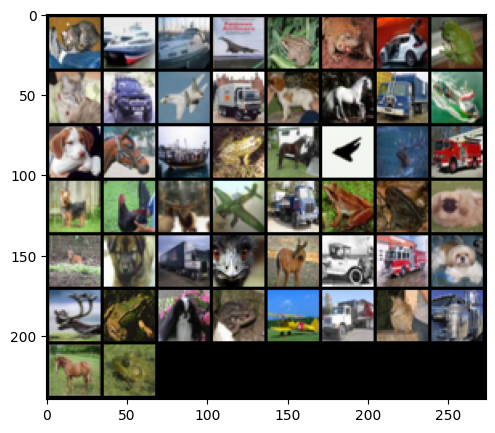

In [7]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

net.eval()
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [8]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([5, 9, 8, 8, 4, 6, 3, 4, 2, 8, 8, 9, 6, 1, 9, 2, 5, 7, 8, 6, 7, 2, 0, 9,
        7, 2, 7, 7, 1, 6, 6, 2, 5, 6, 9, 1, 2, 9, 9, 5, 0, 4, 9, 4, 0, 9, 6, 8,
        4, 4])

In [9]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'airplane' 'frog' 'frog' 'automobile' 'frog' 'cat'
 'automobile' 'airplane' 'truck' 'dog' 'horse' 'truck' 'ship' 'dog'
 'horse' 'ship' 'frog' 'horse' 'airplane' 'deer' 'truck' 'dog' 'bird'
 'deer' 'airplane' 'truck' 'frog' 'frog' 'dog' 'deer' 'dog' 'truck' 'bird'
 'deer' 'automobile' 'truck' 'dog' 'deer' 'frog' 'dog' 'frog' 'airplane'
 'truck' 'cat' 'truck' 'horse' 'frog']
['dog' 'truck' 'ship' 'ship' 'deer' 'frog' 'cat' 'deer' 'bird' 'ship'
 'ship' 'truck' 'frog' 'automobile' 'truck' 'bird' 'dog' 'horse' 'ship'
 'frog' 'horse' 'bird' 'airplane' 'truck' 'horse' 'bird' 'horse' 'horse'
 'automobile' 'frog' 'frog' 'bird' 'dog' 'frog' 'truck' 'automobile'
 'bird' 'truck' 'truck' 'dog' 'airplane' 'deer' 'truck' 'deer' 'airplane'
 'truck' 'frog' 'ship' 'deer' 'deer']
Accuracy is 0.36
